In [1]:
#Imports
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import netCDF4
from shapely.geometry import Point, LineString, MultiPoint
from scipy.interpolate import griddata
import scipy.interpolate
import cmocean
from sklearn import datasets, preprocessing
from eofs.standard import Eof                              #EOFs!!
from eofs.multivariate.standard import MultivariateEof
from scipy import stats

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/')
#Import custom functions
from read_CTD import read_CTD    #To read CTD files
from out_outliers import out_outliers     #To replace outliers
import plotting_functions as plot   #To plot vertical profiles, T-S and vertical sections
from maps import mapa, map_layers    #To plot maps
from stations import stations
from transsects import select_transsects
from dict_units import dict_units

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/distance')
from distances import *

from matplotlib.colors import Normalize
class PiecewiseNorm(Normalize):
    def __init__(self, levels, clip=False):
        # the input levels
        self._levels = np.sort(levels)
        # corresponding normalized values between 0 and 1
        self._normed = np.linspace(0, 1, len(levels))
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return np.ma.masked_array(np.interp(value, self._levels, self._normed))

In [2]:
#Select properties for the analysis

#Transsects
transsects_selected = [1,2,3,4,5,6]

#Remove the surface layer to make the analysis (False or meters to remove)
#surf_layer_out = False
surf_layer_out = 58

#variables
variables = ['temperature','salinity','oxygen']

#Save plots (False or the folder path)
path = False
#path = 'C:/Users/pauab/Universidad/TFM/Figuras/EOF/'

In [3]:
#Import a dictionary with the units of the variables
units = dict_units(variables)

In [4]:
#Data reading and outlier replacement
data_dirs = ['C:/Users/pauab/Universidad/Data/TFM/CTD_recalc/']
data=read_CTD(data_dirs)

for ncast in data.keys():
    for variable in data[ncast].columns:
        out_outliers(data, ncast, variable)
    data[ncast]['pressure'] = data[ncast].index
    data[ncast].index = np.arange(0, len(data[ncast].index))

#Dict with all transsects
all_transsects = {'transsect_0':['15','12','13','14'],
                  'transsect_1':['19','18','17','16'],
                  'transsect_2':['24','23','22','21'],
                  'transsect_3':['26','27','28','29'],
                  'transsect_4':['31','32','33','34'],
                  'transsect_5':['38','37','36','35'],
                  'transsect_6':['43','44','45','46']}

#Dict with the stations grouped according to its position
all_stations_grouped = {}
for i in range(len(list(all_transsects.values())[0])):
    key = 'stations_'+str(i+1)
    all_stations_grouped[key]=[]
    for transsect in all_transsects.values():
        all_stations_grouped[key].append(transsect[i])

C:\Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions\read_CTD.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i].rename(columns=name_columns, inplace=True)


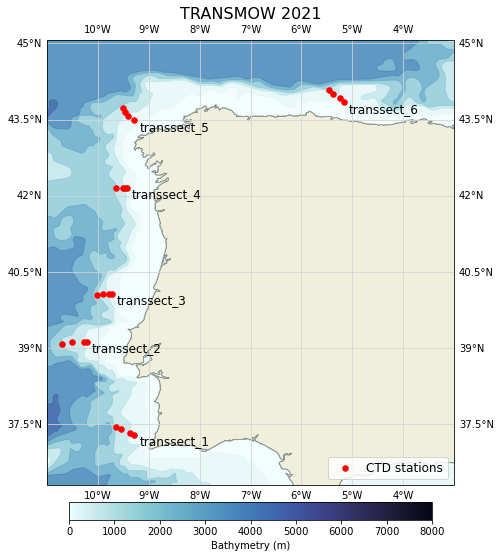

In [5]:
transsects_ncast, stations_grouped = select_transsects(all_transsects, transsects_selected)

#Map the transsects
path = 'C:/Users/pauab/Universidad/TFM/Figuras/maps/'

ncasts = np.array(list(transsects_ncast.values())).reshape(len(transsects_ncast)*len(stations_grouped))
mapa(data, ncasts, labels=False, xoffset=2, yoffset=1, transsects=transsects_ncast, xlim=(-11,-3), savefig=False, path=path)

In [6]:
#Erase the surface layer to avoid noise into the analysis of the water masses
if surf_layer_out != False:
    for ncast in data.keys():
        data[ncast].iloc[0:surf_layer_out] = np.nan

#Extract the reference depth for each station
#We will cut the CTD datasets according to the reference depth for each station
ref_deps={} 
for i in range(len(stations_grouped)):   #iterate over number of transsect stations
    dep_trans=[]
    for ncasts in transsects_ncast.values():
        dep=len(data[ncasts[i]].index)
        dep_trans.append(dep)
    key=str('station_'+str(i))
    ref_deps[key]=min(dep_trans)
print(ref_deps)

list_refdeps = list(ref_deps.values())

## Limiting the CTD datasets to the reference depths stablished
i = 0
for ncasts in stations_grouped.values():
    for ncast in ncasts:
        data[ncast]=data[ncast].iloc[0:list_refdeps[i]]
    i+=1

{'station_0': 1789, 'station_1': 1374, 'station_2': 969, 'station_3': 454}


In [7]:
#Define dimensions
variables = ['temperature','salinity','oxygen']
n_var = len(variables)
n_trans = len(transsects_ncast)
n_stat = len(stations_grouped)
n_dep = max(list_refdeps)

dataset = {}
for variable in variables:
    data_mx = np.zeros(shape=(n_trans, n_stat, n_dep))
    data_mx[:] = np.nan
    for a in range(n_trans):
        transsect = list(transsects_ncast.values())[a]
        for b in range(n_stat):
            ncast = transsect[b]
            var = data[ncast][variable].values
            length = len(var)
            data_mx[a][b][0:length] = var
    vector_data = data_mx.reshape(n_trans*n_stat*n_dep)
    mean_data = np.nanmean(vector_data)
    std_data = np.nanstd(vector_data)
    data_mx = (data_mx - mean_data)/std_data
    print(variable, ' - standardized data')
    print('mean='+str(round(np.nanmean(data_mx),2)))
    print('std='+str(round(np.nanstd(data_mx),2)))
    print()
    dataset[variable] = data_mx

temperature  - standardized data
mean=0.0
std=1.0

salinity  - standardized data
mean=-0.0
std=1.0

oxygen  - standardized data
mean=0.0
std=1.0



In [8]:
#Applying the EOF analysis to the three datamatrix

#Center True is to compute the EOFs of the anomalies (removing the time mean for each point)
center = True
#center = False

temp = dataset['temperature']
sal = dataset['salinity']
oxy = dataset['oxygen']

#Create a solver to compute the analysis
solver = MultivariateEof(datasets=[temp,sal,oxy], weights=None, center=center, ddof=1)

# Retrieve the n_leading EOF
neofs = 3
eof_corr = solver.eofsAsCorrelation(neofs=neofs)
eof_cov = solver.eofsAsCovariance(neofs=neofs, pcscaling=0)
eof = solver.eofs(neofs=neofs, eofscaling=0)

#Variances of the EOFs
variances = np.around(solver.varianceFraction(neigs=neofs)*100,2)

#Cheks
print('len(eof) =',len(eof),'--> returns the eofs for each variable')
print('eof[0].shape =', eof[0].shape,'--> the dims of each variable eof are (neof, nstat, ndep)')
print()
for i in range(len(variances)):
    print('variance of the EOF nº ',str(i+1),' = ',variances[i],'%')

len(eof) = 3 --> returns the eofs for each variable
eof[0].shape = (3, 4, 1789) --> the dims of each variable eof are (neof, nstat, ndep)

variance of the EOF nº  1  =  88.59 %
variance of the EOF nº  2  =  6.01 %
variance of the EOF nº  3  =  2.51 %


In [9]:
#Convert the NaNs to 0 values to be able to plot them (some plotting functions have problems with the nans interpolations)
eof = np.nan_to_num(eof)
eof_cov = np.nan_to_num(eof_cov)
eof_corr = np.nan_to_num(eof_corr)

# Plot the PCs

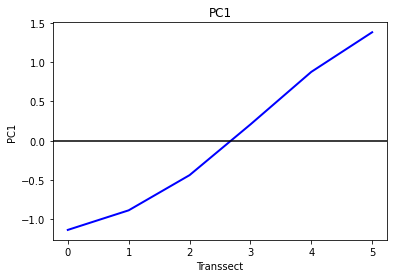

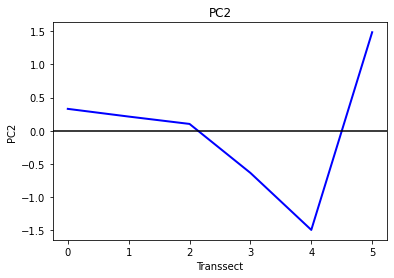

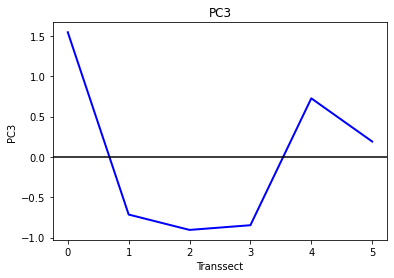

In [10]:
# Plot the selected PC 
path = False

for i in range(neofs):
    ieof = i
    
    if surf_layer_out == False:
        name_pc = 'pc'+str(ieof+1)+'t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])
    else:
        name_pc = 'pc'+str(ieof+1)+'t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'nosurflayer'+str(surf_layer_out)

    pc = solver.pcs(npcs=neofs, pcscaling=1) 
    
    plt.figure()
    plt.plot(np.arange(n_trans), pc[:,ieof], color='b', linewidth=2)
    plt.axhline(0, color='k')
    plt.title('PC'+str(ieof+1))
    plt.xlabel('Transsect')
    plt.ylabel('PC'+str(ieof+1))

    if path != False:
        plt.savefig(path+name_pc+'.jpg') 

    plt.show()

# Plot the EOFs

In [11]:
#Create a concatenate DataFrame of the EOFs matrix stored in a dict to ease the plotting

#We established that the stations are all equally separated to ease the plotting work (which it is not true)
dist = np.linspace(0,3,4)

#Create a DataFrame for each EOFs variant and for each variable stored in a dic
data_plot = {}
for a in range(len(variables)):
    var = variables[a]
    data_plot[var] = {}
    for b in range(neofs):
        key = 'eof'+str(b+1)
        data_plot[var][key] = {}
        data_conc = pd.DataFrame(dtype='float64')
        for c in range(n_stat):
            dic = {'eof':eof[a][b][c],
                   'eof_cov':eof_cov[a][b][c],
                   'eof_corr':eof_corr[a][b][c],
                   'x':dist[c],
                   'depth':np.linspace(0,n_dep-1,n_dep)}
            df = pd.DataFrame(dic)
            if data_conc.empty:
                data_conc = df
            else:
                data_conc = pd.concat([data_conc, df])
        data_plot[var][key] = data_conc

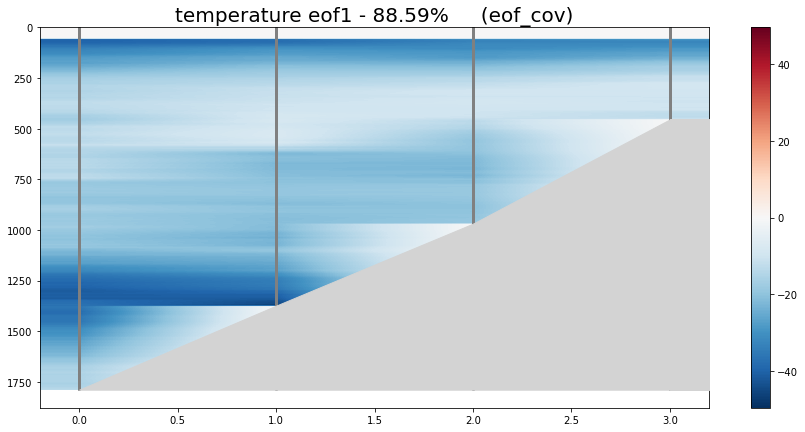

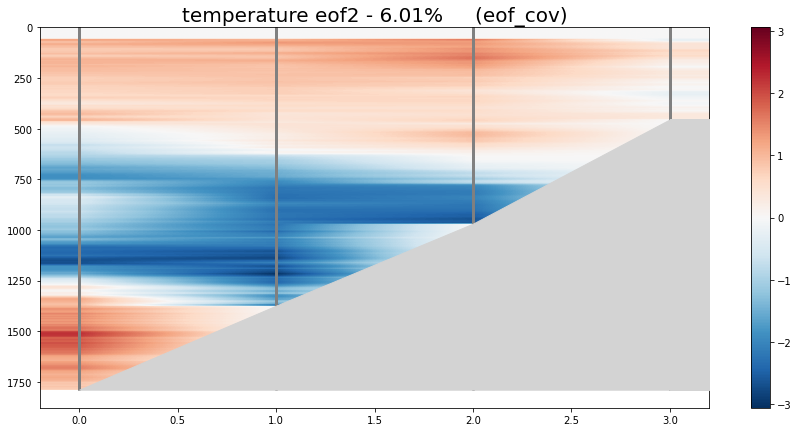

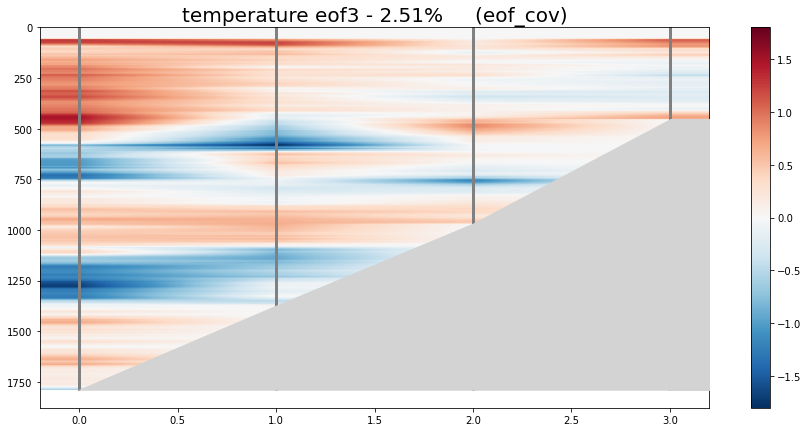

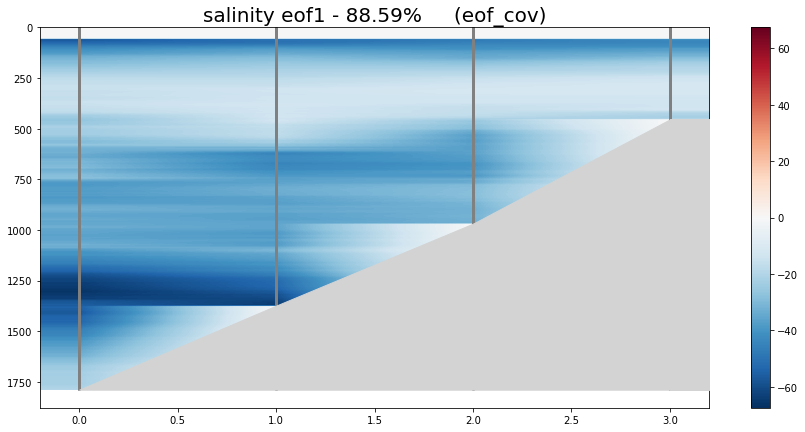

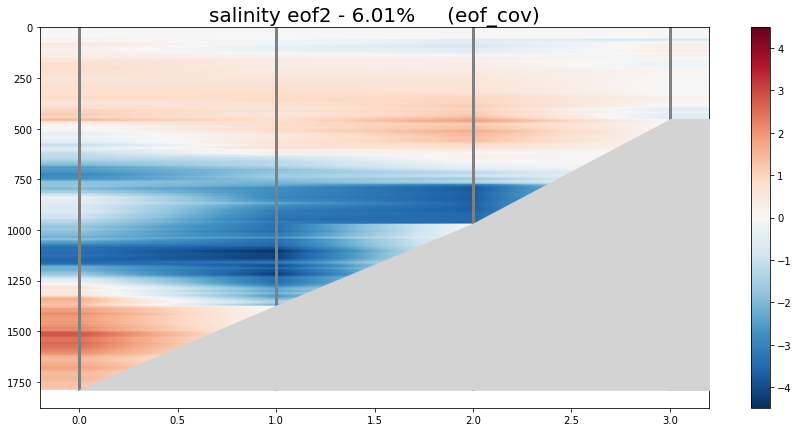

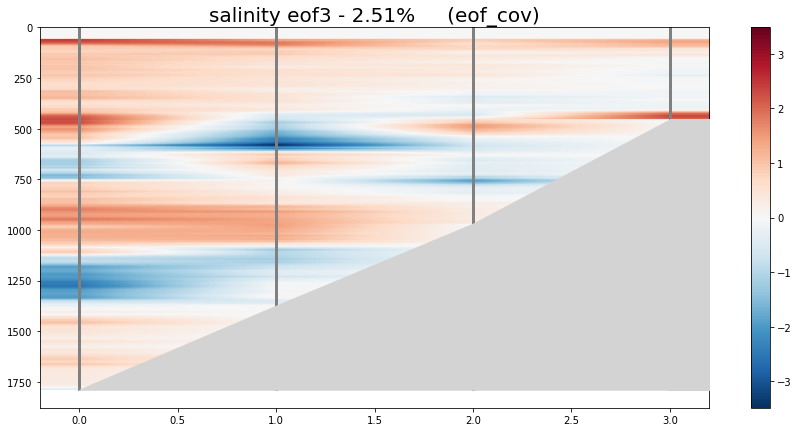

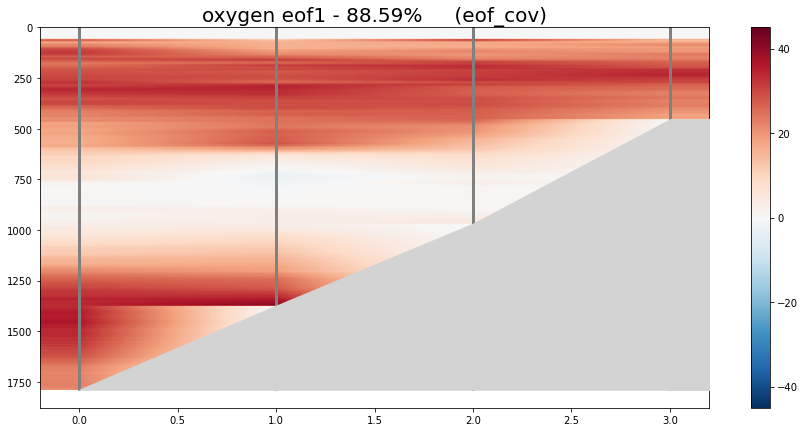

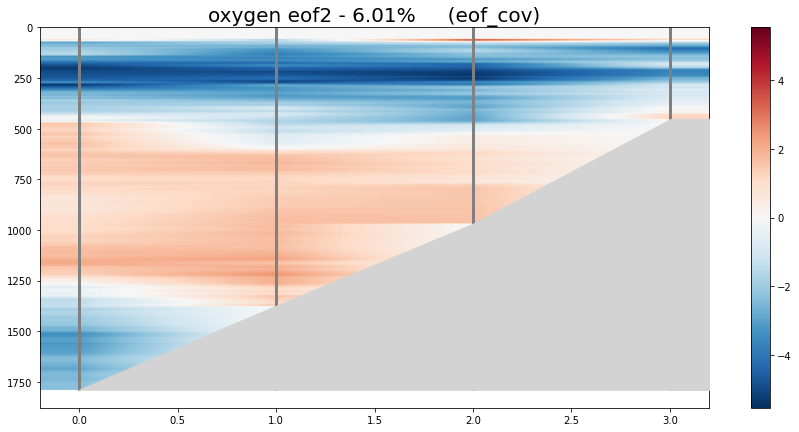

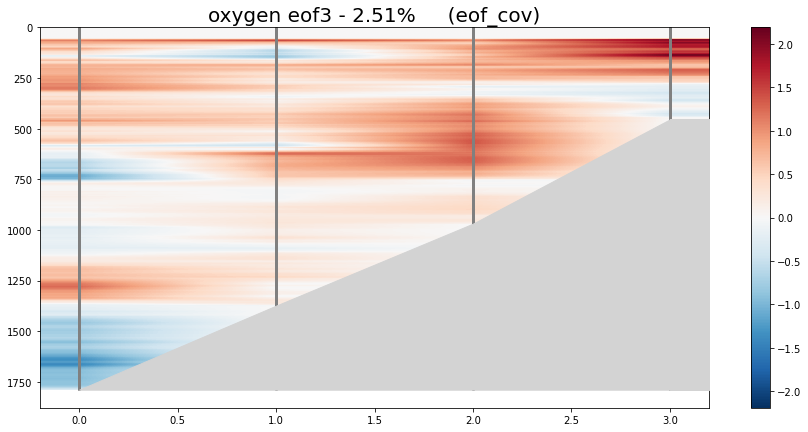

In [12]:
#path_figs = 'C:/Users/pauab/Universidad/TFM/Figuras/EOF/EOF_multivariate/'
path = False

interpolation = 'linear'    #Other options are multiquadric, inverse, gaussian, antialiased, nearest...

#Choose color map
cmap = 'RdBu_r'
#cmap = cmocean.cm.ice_r
#cmap = 'viridis'
#cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

dist = np.linspace(0,3,4)

for variable in variables:
    for i in range(neofs):
        ieof = 'eof'+str(i+1)
        
        #EOF variant
        #eof_type = 'eof'
        eof_type = 'eof_cov'
        #eof_type = 'eof_corr'

        #To plot properly using the plt.imshow we need to transpose the mx
        X = np.transpose(np.array(data_plot[variable][ieof][eof_type]).reshape(n_stat,n_dep), (1,0))

        #Plotting
        plt.subplots(figsize=(15,7))

        plt.xlim(-0.2,3.2)

        #If we want the white color to be the 0 value, we have to adjust the properties of the color bar (adjust the maxs and minimums values)
        if abs(np.nanmax(X)) > abs(np.nanmin(X)):            #in case the absolute highest value is positive
            vmax, vmin = np.nanmax(X), -np.nanmax(X)
        else:                                                #in case the absolute highest value is negative
            vmax, vmin = -np.nanmin(X), np.nanmin(X)

        a = plt.imshow(X, aspect='auto', cmap=cmap, interpolation='bilinear', interpolation_stage='none', vmax=vmax, vmin=vmin)
        #a = plt.imshow(X, aspect='auto', cmap=cmap, interpolation='bilinear', interpolation_stage='none')
        plt.scatter(data_plot[variable][ieof]['x'], data_plot[variable][ieof]['depth'], c='grey', s=2)
        plt.colorbar(a)
        plt.fill_between(dist, list_refdeps, max(list_refdeps), color='lightgray', zorder=99)
        plt.fill_between([3,3.2],min(list_refdeps),max(list_refdeps),color='lightgray', zorder=99)

        if ieof == 'eof1':
            plt.title(variable+' '+str(ieof)+' - '+str(variances[0])+'%     ('+eof_type+')',fontsize=20)
        if ieof == 'eof2':
            plt.title(variable+' '+str(ieof)+' - '+str(variances[1])+'%     ('+eof_type+')',fontsize=20)
        if ieof == 'eof3':
            plt.title(variable+' '+str(ieof)+' - '+str(variances[2])+'%     ('+eof_type+')',fontsize=20)

        if surf_layer_out != False:
            name_eof = str(ieof)+'_'+variable+'_'+eof_type+'t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'nosurflayer'+str(surf_layer_out)
        else:
            name_eof = str(ieof)+'_'+variable+'_'+eof_type+'t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])

        if path != False:
            plt.savefig(path+name_eof+'.jpg', dpi=300)

        plt.show()

# PC series x VARIABLE

In [13]:
#To project the EOFs into the variable values, we will make a linear regression between 
#the variable values of the transsects and its associate principal component (pc)

variables = ['temperature','salinity','oxygen']
n_trans = len(transsects_ncast)
n_stat = len(stations_grouped)
n_dep = max(list_refdeps)

dataset = {}
#Create the datamatrixs
for variable in variables:
    data_mx = np.zeros(shape=(n_trans, n_stat, n_dep))   #Creates the matrix with dimensions (n_trans, n_stat,n_dep)
    data_mx[:]=np.nan                                    #Fills the mx with nans
    #Fill the mx with the variable values
    a = 0
    for ncasts in transsects_ncast.values():
        b = 0
        for ncast in ncasts:                                       #iterate over stations
            var = data[ncast][variable].values
            length = len(var)
            data_mx[a][b][0:length] = var                          #Insert the values std into the datamatrix
            b+=1
        a+=1
    dataset[variable] = data_mx

In [14]:
variables = ['temperature','salinity','oxygen']

#Create a concatenate DataFrame of the EOFs matrix stored in a dict to ease the plotting

#We established that the stations are all equally separated to ease the plotting work (which it is not true)i
#dist = np.linspace(0,1,4)
dist = np.linspace(0, 3, 4)

data_reg = {}
for a in range(len(variables)):
    var = variables[a]
    data_reg[var] = {}
    for b in range(neofs):
        key = 'eof'+str(b+1)
        data_reg[var][key] = {}
        reg = np.zeros(shape=(n_stat, n_dep))
        reg[:,:] = np.nan
        for c in range(n_stat):
            for d in range(n_dep):
                linreg = stats.linregress(pc[:,b], dataset[var][:,c,d])
                reg[c,d] = linreg.slope
        reg = np.nan_to_num(reg)
        data_reg[var][key] = reg

data_plot_proj = {}
for a in range(len(variables)):
    var = variables[a]
    data_plot_proj[var] = {}
    for b in range(neofs):
        key = 'eof'+str(b+1)
        reg = np.zeros(shape=(n_stat, n_dep))
        reg[:,:] = np.nan
        for c in range(n_stat):
            for d in range(n_dep):
                linreg = stats.linregress(pc[:,b], dataset[var][:,c,d])
                reg[c,d] = linreg.slope
        reg = np.nan_to_num(reg)
        data_plot_proj[var][key] = {}
        data_conc = pd.DataFrame(dtype='float64')
        for c in range(n_stat):
            dic = {'reg':reg[c],
                   'x':dist[c],
                   'depth':np.linspace(0,n_dep-1,n_dep)}
            df = pd.DataFrame(dic)
            if data_conc.empty:
                data_conc = df
            else:
                data_conc = pd.concat([data_conc, df])
        data_plot_proj[var][key] = data_conc

# FINAL PLOTS

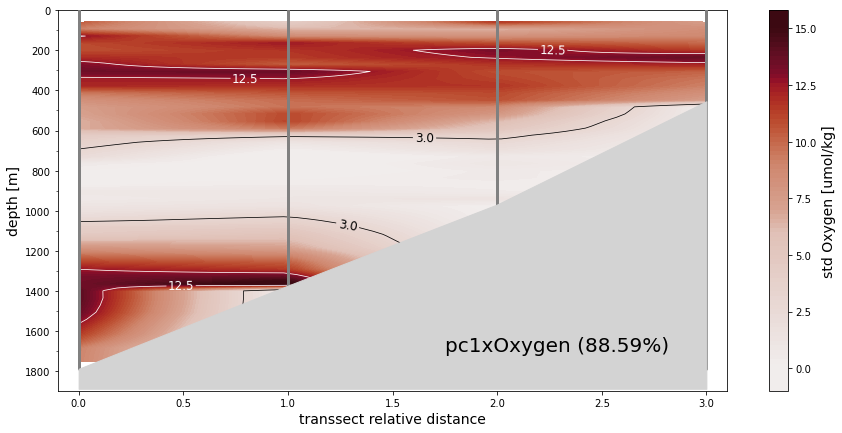

In [16]:
path = 'C:/Users/pauab/Universidad/TFM/Figuras/EOF/final_figures/'
path = False
extension = '.png'

variable = 'oxygen'
ieof = 'eof1'
cmap = cmocean.cm.amp
#cmap = cmocean.cm.ice
interpolation = 'linear'
xoffset = 0.1
fontsize_title = 20
fontsize_label = 14

#plotting
fig, ax0 = plt.subplots(1,1, figsize=(15,7))

#limits
ax0.set_xlim(0-xoffset,3+xoffset)
ax0.set_ylim(n_dep+110, 0)
ax0.margins(0.05)

#ticks
ax0.set_yticks(np.arange(0,1900,200))
ax0.set_yticks(np.arange(0,1900,100), minor=True)

#Bathymetry
ax0.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)
#ax0.fill_between([0,3],10,100, color='white', zorder=5)

#Creating the grid
points = list(zip(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth']))
xi, yi = np.mgrid[0:3:50j, surf_layer_out:n_dep:50j]

vmin = np.nanmin(data_reg[variable][ieof])
vmax = np.nanmax(data_reg[variable][ieof])

grid_ztest = griddata(points, np.nan_to_num(data_plot_proj[variable][ieof]['reg']), (xi, yi), method=interpolation, rescale=True)
#grid_ztest = griddata(points, data_plot_proj[variable][ieof]['reg'], (xi, yi), method=interpolation, rescale=True)
#grid_ztest = np.nan_to_num(grid_ztest)

#Colouring the grid
#levels = [0, -0.1, -0.2, -0.225, -0.25, -0.275, -0.3, -0.325, -0.35]
levels = [0, 2, 4, 6, 6.5, 7, 8, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 12.75, 13, 13.5, 14, 14.5, 15]
#levels = [0, 5, 10, 11, 12, 13, 15, 17, 19]

handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
#handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, levels=100)

#if abs(grid_ztest.max()) > abs(grid_ztest.min()):
#    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=grid_ztest.max(), vmin=-grid_ztest.max())
#else:
#    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=-grid_ztest.min(), vmin=grid_ztest.min())

#plotting the stations
b = ax0.scatter(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth'], c='grey', s=2, zorder=10)

#contouring 
clevels = [3, 12.5]
#offset = (abs(vmin) + abs(vmax))/10
#clevels = np.linspace(vmin+offset, vmax+offset, 4)
CS = ax0.contour(xi, yi, grid_ztest, levels=clevels, colors=['k','white','white','white'], linewidths=0.75)
ax0.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=12, zorder=20)

#colorbar
cb = fig.colorbar(handle, ax=ax0, ticks=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
#cb = fig.colorbar(handle, ax=ax0)
cb.set_label(label='std '+variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)
plt.text(1.75, 1700, 'pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+' ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title, zorder=100)
#plt.title('pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+'       ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title)

#if surf_layer_out == False:
#    name_pcxvar = 'pc'+str(ieof[3])+'x'+variable+'t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'_contours'     #name for the pcxvar figures
#else:
#    name_pcxvar = 'pc'+str(ieof[3])+'x'+variable+'t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'nosurflayer'+str(surf_layer_out)+'_contours'
name_pcxvar = 'pc'+str(ieof[3])+'x'+variable+'_t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'_'+str(len(clevels))+'contours'

if path != False:
    plt.savefig(path+name_pcxvar+'_Orecalc'+extension, dpi=300) 

plt.show()

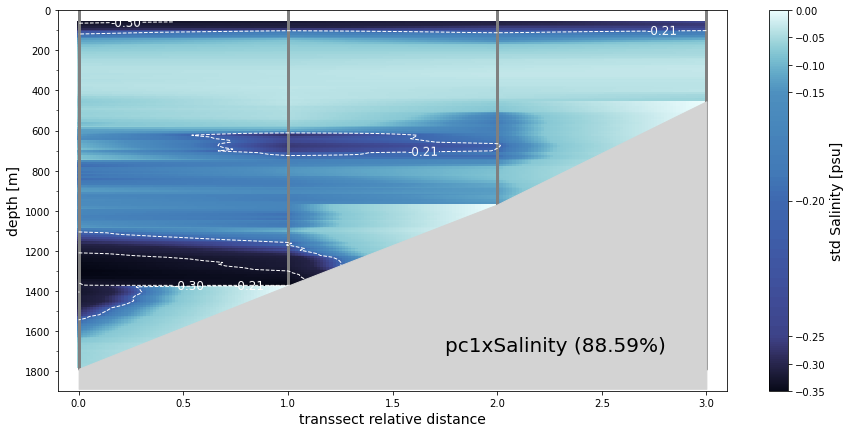

In [26]:
path = 'C:/Users/pauab/Universidad/TFM/Figuras/EOF/final_figures/'
path = False
extension = '.png'

variable = 'salinity'
ieof = 'eof1'
cmap = cmocean.cm.ice

#plotting
fig, ax0 = plt.subplots(1,1, figsize=(15,7))

#limits
ax0.set_xlim(0-xoffset,3+xoffset)
ax0.set_ylim(n_dep+110, 0)
ax0.margins(0.05)

#ticks
ax0.set_yticks(np.arange(0,1900,200))
ax0.set_yticks(np.arange(0,1900,100), minor=True)

#Bathymetry
ax0.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)

#Creating the grid
points = list(zip(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth']))
xi, yi = np.mgrid[0:3:200j, surf_layer_out:n_dep:200j]

vmin = np.nanmin(data_reg[variable][ieof])
vmax = np.nanmax(data_reg[variable][ieof])

grid_ztest = griddata(points, np.nan_to_num(data_plot_proj[variable][ieof]['reg']), (xi, yi), method=interpolation, rescale=True)
#grid_ztest = griddata(points, data_plot_proj[variable][ieof]['reg'], (xi, yi), method=interpolation, rescale=True)
#grid_ztest = np.nan_to_num(grid_ztest)

#Colouring the grid
#levels = [0, -0.05, -0.1, -0.15, -0.2, -0.25, -0.27, -0.29, -0.31, -0.33, -0.35]
#levels = [0, -0.2, -0.225, -0.25, -0.275, -0.3, -0.325, -0.35]
levels = [0, -0.05, -0.1, -0.15, -0.16, -0.17, -0.18, -0.2, -0.21, -0.22, -0.23, -0.24, -0.25, -0.3, -0.35]

handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), shading='auto')

#if abs(grid_ztest.max()) > abs(grid_ztest.min()):
#    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=grid_ztest.max(), vmin=-grid_ztest.max())
#else:
#    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=-grid_ztest.min(), vmin=grid_ztest.min())

#plotting the stations
b = ax0.scatter(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth'], c='grey', s=2, zorder=1)

#contouring 
clevels = [-0.3, -0.21]
#offset = (abs(vmin) + abs(vmax))/10
#clevels = np.linspace(vmin+offset, vmax+offset, 4)
CS = ax0.contour(xi, yi, grid_ztest, levels=clevels, colors='white', linewidths=1)
ax0.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=12)

#colorbar
cb = fig.colorbar(handle, ax=ax0, ticks=[-0.35, -0.30, -0.25, -0.20, -0.15, -0.10, -0.05, 0])
cb.set_label(label='std '+variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)
#plt.title('pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+'       ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title)
plt.text(1.75, 1700, 'pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+' ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title, zorder=100)

name_pcxvar = 'pc'+str(ieof[3])+'x'+variable+'_t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'_'+str(len(clevels))+'contours'

if path != False:
    plt.savefig(path+name_pcxvar+'_Orecalc_v2'+extension, dpi=300) 

plt.show()

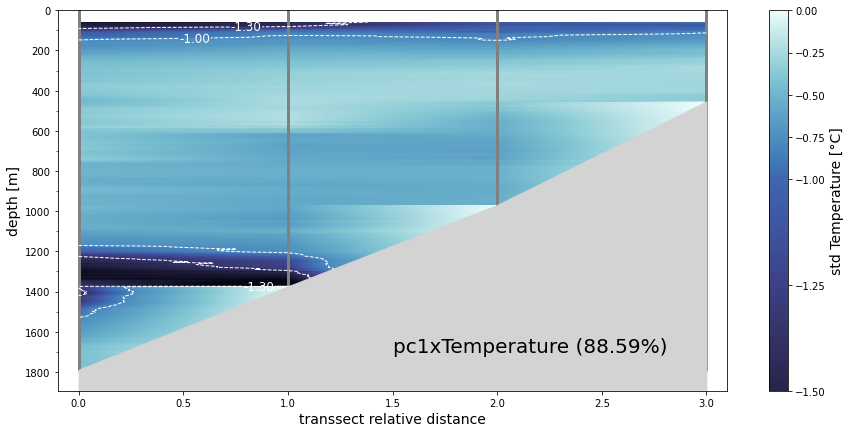

In [18]:
path = 'C:/Users/pauab/Universidad/TFM/Figuras/EOF/final_figures/'
path = False
extension = '.png'

variable = 'temperature'
ieof = 'eof1'
cmap = cmocean.cm.ice
interpolation = 'linear'
xoffset = 0.1
fontsize_title = 20
fontsize_label = 14

#plotting
fig, ax0 = plt.subplots(1,1, figsize=(15,7))

#limits
ax0.set_xlim(0-xoffset,3+xoffset)
ax0.set_ylim(n_dep+105, 0)
ax0.margins(0.05)

#ticks
ax0.set_yticks(np.arange(0,1900,200))
ax0.set_yticks(np.arange(0,1900,100), minor=True)

#Bathymetry
ax0.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)

#Creating the grid
points = list(zip(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth']))
xi, yi = np.mgrid[0:3:500j, surf_layer_out:n_dep:500j]

vmin = np.nanmin(data_reg[variable][ieof])
vmax = np.nanmax(data_reg[variable][ieof])

grid_ztest = griddata(points, np.nan_to_num(data_plot_proj[variable][ieof]['reg']), (xi, yi), method=interpolation, rescale=True)
#grid_ztest = griddata(points, data_plot_proj[variable][ieof]['reg'], (xi, yi), method=interpolation, rescale=True)
#grid_ztest = np.nan_to_num(grid_ztest)

#Colouring the grid
#levels = [0, -0.25, -0.5, -0.75, -1, -1.1, -1.2, -1.3, -1.4, -1.5, -1.6]
levels = [0, -0.25, -0.5, -0.75, -1, -1.1, -1.15, -1,20,-1.25, -1.3, -1.35, -1.40, -1.45, -1.50]
levels = [0, -0.25, -0.5, -0.75, -1, -1.1, -1.2, -1.3, -1.4, -1.5]
#levels = [0, -0.5, -1, -1.1, -1.2, -1.3, -1.4, -1.5]
#levels = [0, -0.25, -0.5, -0.75, -1, -1.25, -1.35, -1.45, -1.55, -1.65]

handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), shading='auto')
#handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')

#if abs(grid_ztest.max()) > abs(grid_ztest.min()):
#    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=grid_ztest.max(), vmin=-grid_ztest.max())
#else:
#    handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, vmax=-grid_ztest.min(), vmin=grid_ztest.min())

#plotting the stations
b = ax0.scatter(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth'], c='grey', s=2, zorder=1)

#contouring 
clevels = [-1.3,-1]
#offset = (abs(vmin) + abs(vmax))/10
#clevels = np.linspace(vmin+offset, vmax+offset, 4)
CS = ax0.contour(xi, yi, grid_ztest, levels=clevels, colors='white', linewidths=1)
ax0.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=12)

#colorbar
#cb = fig.colorbar(handle, ax=ax0)
cb = fig.colorbar(handle, ax=ax0, ticks=[-1.5, -1.25, -1, -0.75, -0.5, -0.25, 0])
cb.set_label(label='std '+variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)
#plt.title('pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+'       ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title)
plt.text(1.5, 1700, 'pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+' ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title, zorder=100)

name_pcxvar = 'pc'+str(ieof[3])+'x'+variable+'_t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'_'+str(len(clevels))+'contours'

if path != False:
    plt.savefig(path+name_pcxvar+'_Orecalc'+extension, dpi=300) 
    
plt.show()

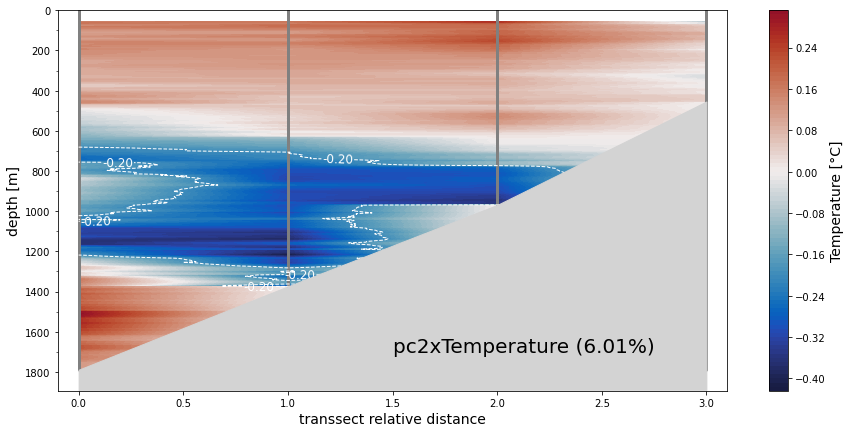

In [19]:
path = 'C:/Users/pauab/Universidad/TFM/Figuras/EOF/final_figures/'
path = False
extension = '.png'

variable = 'temperature'
ieof = 'eof2'
cmap = cmocean.cm.balance
interpolation = 'linear'
xoffset = 0.1
fontsize_title = 20
fontsize_label = 14

#plotting
fig, ax0 = plt.subplots(1,1, figsize=(15,7))

#limits
ax0.set_xlim(0-xoffset,3+xoffset)
ax0.set_ylim(n_dep+105, 0)
ax0.margins(0.05)

#ticks
ax0.set_yticks(np.arange(0,1900,200))
ax0.set_yticks(np.arange(0,1900,100), minor=True)

#Bathymetry
ax0.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)

#Creating the grid
points = list(zip(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth']))
xi, yi = np.mgrid[0:3:500j, surf_layer_out:n_dep:500j]

vmin = np.nanmin(data_reg[variable][ieof])
vmax = np.nanmax(data_reg[variable][ieof])

grid_ztest = griddata(points, np.nan_to_num(data_plot_proj[variable][ieof]['reg']), (xi, yi), method=interpolation, rescale=True)
#grid_ztest = griddata(points, data_plot_proj[variable][ieof]['reg'], (xi, yi), method=interpolation, rescale=True)
#grid_ztest = np.nan_to_num(grid_ztest)

#Colouring the grid
#levels = [0, -0.25, -0.5, -0.75, -1, -1.1, -1.2, -1.3, -1.4, -1.5, -1.6]
levels = [0, -0.25, -0.5, -0.75, -1, -1.1, -1.15, -1,20,-1.25, -1.3, -1.35, -1.40, -1.45, -1.50]
levels = [0, -0.5, -1, -1.1, -1.2, -1.3, -1.4, -1.5]
#levels = [0, -0.25, -0.5, -0.75, -1, -1.25, -1.35, -1.45, -1.55, -1.65]

#handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), shading='auto')
#handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
#handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)

if abs(grid_ztest.max()) > abs(grid_ztest.min()):
    handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, vmax=np.nanmax(grid_ztest), vmin=-np.nanmax(grid_ztest), levels=100)
else:
    handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, vmax=-np.nanmin(grid_ztest), vmin=np.nanmin(grid_ztest), levels=100)

#plotting the stations
b = ax0.scatter(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth'], c='grey', s=2, zorder=1)

#contouring 
clevels = [-0.2]
#offset = (abs(vmin) + abs(vmax))/10
#clevels = np.linspace(vmin+offset, vmax+offset, 4)
CS = ax0.contour(xi, yi, grid_ztest, levels=clevels, colors='white', linewidths=1)
ax0.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=12)

#colorbar
cb = fig.colorbar(handle, ax=ax0)
#cb = fig.colorbar(handle, ax=ax0, ticks=[-1.5, -1.25, -1, -0.75, -0.5, -0.25, 0])
cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)
#plt.title('pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+'       ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title)
plt.text(1.5, 1700, 'pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+' ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title, zorder=100)

name_pcxvar = 'pc'+str(ieof[3])+'x'+variable+'_t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'_'+str(len(clevels))+'contours'

if path != False:
    plt.savefig(path+name_pcxvar+'_v3'+extension, dpi=300) 
    
plt.show()

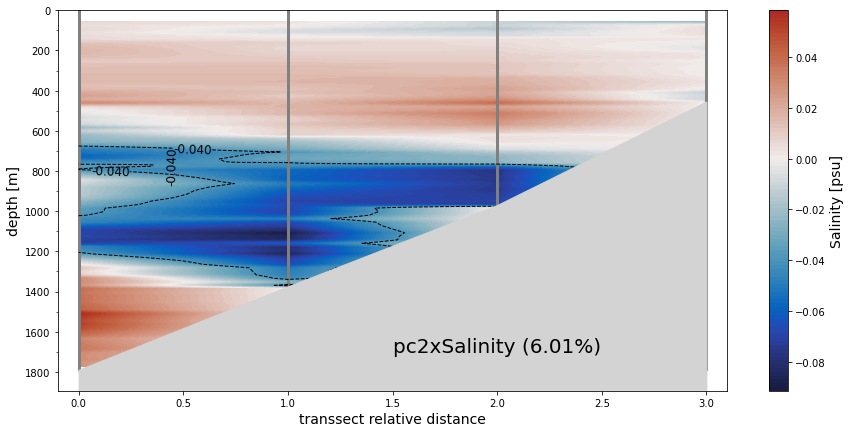

In [20]:
path = 'C:/Users/pauab/Universidad/TFM/Figuras/EOF/final_figures/'
path = False
extension = '.png'

variable = 'salinity'
ieof = 'eof2'
cmap = cmocean.cm.balance
interpolation = 'linear'
xoffset = 0.1
fontsize_title = 20
fontsize_label = 14

#plotting
fig, ax0 = plt.subplots(1,1, figsize=(15,7))

#limits
ax0.set_xlim(0-xoffset,3+xoffset)
ax0.set_ylim(n_dep+105, 0)
ax0.margins(0.05)

#ticks
ax0.set_yticks(np.arange(0,1900,200))
ax0.set_yticks(np.arange(0,1900,100), minor=True)

#Bathymetry
ax0.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)

#Creating the grid
points = list(zip(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth']))
xi, yi = np.mgrid[0:3:100j, surf_layer_out:n_dep:100j]

vmin = np.nanmin(data_reg[variable][ieof])
vmax = np.nanmax(data_reg[variable][ieof])

grid_ztest = griddata(points, np.nan_to_num(data_plot_proj[variable][ieof]['reg']), (xi, yi), method=interpolation, rescale=True)
#grid_ztest = griddata(points, data_plot_proj[variable][ieof]['reg'], (xi, yi), method=interpolation, rescale=True)
#grid_ztest = np.nan_to_num(grid_ztest)

#Colouring the grid
#levels = [0, -0.25, -0.5, -0.75, -1, -1.1, -1.2, -1.3, -1.4, -1.5, -1.6]
#levels = [0, -0.25, -0.5, -0.75, -1, -1.1, -1.15, -1,20,-1.25, -1.3, -1.35, -1.40, -1.45, -1.50]
levels = np.arange(-0.08, 0.09, 0.01)
#levels = [0, -0.25, -0.5, -0.75, -1, -1.25, -1.35, -1.45, -1.55, -1.65]

#handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), shading='auto')
#handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')

if abs(grid_ztest.max()) > abs(grid_ztest.min()):
    handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, vmax=np.nanmax(grid_ztest), vmin=-np.nanmax(grid_ztest), levels=100)
else:
    handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, vmax=-np.nanmin(grid_ztest), vmin=np.nanmin(grid_ztest), levels=100)

#plotting the stations
b = ax0.scatter(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth'], c='grey', s=2, zorder=1)

#contouring 
clevels = [-0.04]
#offset = (abs(vmin) + abs(vmax))/10
#clevels = np.linspace(vmin+offset, vmax+offset, 4)
CS = ax0.contour(xi, yi, grid_ztest, levels=clevels, colors='k', linewidths=1)
ax0.clabel(CS, CS.levels, inline=True, fmt='%1.3f', fontsize=12)

#colorbar
#cb = fig.colorbar(handle, ax=ax0)
cb = fig.colorbar(handle, ax=ax0, ticks = np.arange(-0.08, 0.09, 0.02))
cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)
#plt.title('pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+'       ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title)
plt.text(1.5, 1700, 'pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+' ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title, zorder=100)

name_pcxvar = 'pc'+str(ieof[3])+'x'+variable+'_t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'_'+str(len(clevels))+'contours'

if path != False:
    plt.savefig(path+name_pcxvar+'_v3'+extension, dpi=300) 
    
plt.show()

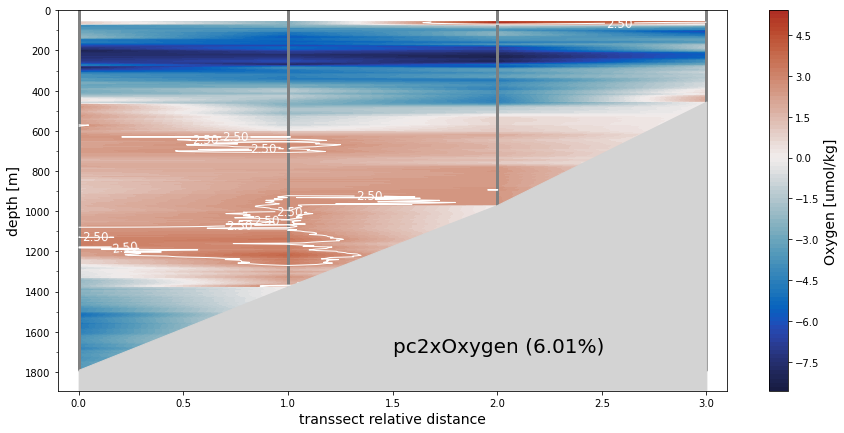

In [21]:
path = 'C:/Users/pauab/Universidad/TFM/Figuras/EOF/final_figures/'
path = False
extension = '.png'

variable = 'oxygen'
ieof = 'eof2'
cmap = cmocean.cm.balance
interpolation = 'linear'
xoffset = 0.1
fontsize_title = 20
fontsize_label = 14

#plotting
fig, ax0 = plt.subplots(1,1, figsize=(15,7))

#limits
ax0.set_xlim(0-xoffset,3+xoffset)
ax0.set_ylim(n_dep+105, 0)
ax0.margins(0.05)

#ticks
ax0.set_yticks(np.arange(0,1900,200))
ax0.set_yticks(np.arange(0,1900,100), minor=True)

#Bathymetry
ax0.fill_between(dist,list_refdeps,max(list_refdeps)+100, color='lightgray', zorder=100)

#Creating the grid
points = list(zip(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth']))
xi, yi = np.mgrid[0:3:500j, surf_layer_out:n_dep:500j]

vmin = np.nanmin(data_reg[variable][ieof])
vmax = np.nanmax(data_reg[variable][ieof])

grid_ztest = griddata(points, np.nan_to_num(data_plot_proj[variable][ieof]['reg']), (xi, yi), method=interpolation, rescale=True)
#grid_ztest = griddata(points, data_plot_proj[variable][ieof]['reg'], (xi, yi), method=interpolation, rescale=True)
#grid_ztest = np.nan_to_num(grid_ztest)

#Colouring the grid
#levels = [0, -0.25, -0.5, -0.75, -1, -1.1, -1.2, -1.3, -1.4, -1.5, -1.6]
levels = [0, -0.25, -0.5, -0.75, -1, -1.1, -1.15, -1,20,-1.25, -1.3, -1.35, -1.40, -1.45, -1.50]
levels = [0, -0.5, -1, -1.1, -1.2, -1.3, -1.4, -1.5]
#levels = [0, -0.25, -0.5, -0.75, -1, -1.25, -1.35, -1.45, -1.55, -1.65]

#handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), shading='auto')
#handle = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')
#handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)

if abs(grid_ztest.max()) > abs(grid_ztest.min()):
    handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, vmax=np.nanmax(grid_ztest), vmin=-np.nanmax(grid_ztest), levels=100)
else:
    handle = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, vmax=-np.nanmin(grid_ztest), vmin=np.nanmin(grid_ztest), levels=100)

#plotting the stations
b = ax0.scatter(data_plot_proj[variable][ieof]['x'], data_plot_proj[variable][ieof]['depth'], c='grey', s=2, zorder=1)

#contouring 
clevels = [2.5]
#offset = (abs(vmin) + abs(vmax))/10
#clevels = np.linspace(vmin+offset, vmax+offset, 4)
CS = ax0.contour(xi, yi, grid_ztest, levels=clevels, colors='white', linewidths=1)
ax0.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=12)

#colorbar
cb = fig.colorbar(handle, ax=ax0)
#cb = fig.colorbar(handle, ax=ax0, ticks=[-1.5, -1.25, -1, -0.75, -0.5, -0.25, 0])
cb.set_label(label=variable[0].upper()+variable[1:]+' '+units[variable], fontsize=fontsize_label)

#titles
plt.ylabel('depth [m]', fontsize=fontsize_label)
plt.xlabel('transsect relative distance', fontsize=fontsize_label)
#plt.title('pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+'       ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title)
plt.text(1.5, 1700, 'pc'+str(ieof[3])+'x'+variable[0].upper()+variable[1:]+' ('+str(variances[int(ieof[3])-1])+'%)', fontsize=fontsize_title, zorder=100)

name_pcxvar = 'pc'+str(ieof[3])+'x'+variable+'_t'+str(transsects_selected[0])+'_to_t'+str(transsects_selected[-1])+'_'+str(len(clevels))+'contours'

if path != False:
    plt.savefig(path+name_pcxvar+'_v3'+extension, dpi=300) 
    
plt.show()